<a href="https://colab.research.google.com/github/venomouscyanide/grl/blob/master/assignment1/Assignment_1_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Changelog
This is a fork of https://colab.research.google.com/drive/1ZIoa5VfQzVayf5igY2qdOtcok3sC1RXl with modifications made to the accuracy function

Changes can be summarized as:
- Accuracy is now replaced with 8 different mean squared error columns + one overall average error column(average of the 8 MSE errors values)

    The pseudocode for calculating MSE is as follows:
    ```
    prediction = model(data)
    for dim in range(8):
        MSE_for_stat = MSE(prediction[:, dim], target[:, dim]) # gives 8-d tensor
    ```
    Repeat the above for 3 seeds and take average of the 3 8-d tensors(tensor containing 8 MSE errors captured).
    
    Capture each value in the averaged 8-d tensor(average of 3 random seed runs) in a dataframe with column name being the name of the statistic.
    
    Finally, take average of the 8 values in the averaged out tensor and capture this floating value and call it "Average Error across 8-d"

    _Note: Loss function still remains mean squared error across all training samples_
    
    **Example for 2 rows(each row is the output after running 3 seeds for a given set of hyperparameters)**:
    
    <small>Average Error across 8-d is nothing but the mean of the 8 values
    <a href="https://drive.google.com/uc?export=view&id=1TtVGssb9iqmrzq1KoQbCDpwUKBkKhTK2">
    <img src="https://drive.google.com/uc?export=view&id=1TtVGssb9iqmrzq1KoQbCDpwUKBkKhTK2"
    style="width: 500px; max-width: 100%; height: auto"
    title="Click for the larger version." />
</a>

- Remove testing over downstream tasks, just focus on the training([MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)) error values for each learnt statistic
    


In [ ]:
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install torch-geometric

# All imports

In [ ]:
import time
from copy import deepcopy
import itertools
import random
from typing import List, Union
from cachetools import Cache
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.datasets import *
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import networkx as nx
from networkx.algorithms.centrality import *
from networkx.algorithms.cluster import *
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt

Creating a cache to store the target tensors containing node statistics. Calculating N node statistics(8 in my experiments) multiple times can be compute heavy for graphs with high number of nodes.

In [ ]:
cache = Cache(maxsize=4)

## Increase max rows and cols for dataframes

In [ ]:
pd.set_option('max_rows', 99999)

In [ ]:
pd.set_option('max_colwidth', 400)

# Utility functions
A few utility functions to help understand the datasets.

In [ ]:
def visualize(h: Union[torch.tensor, nx.Graph], color, epoch: int = None, loss=None):
    """
        Helps visualize the graph in a 2d space
    """
    # Taken from https://colab.research.google.com/drive/1CILdAekIkIh-AX2EXwZ3ZsZ6VcCbwc0t?usp=sharing
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(h, pos=None, with_labels=False, node_color=color, cmap="Dark2")
    plt.show()


def show_dataset_as_networkx_graph(data: Dataset):
    """
        Convert PyG dataset into nx graph for visualization
    """
    G = to_networkx(data, to_undirected=False)
    visualize(G, color=data.y)


def show_dataset_stats(dataset: Dataset):
    """
        Show the stats of the dataset
    """
    # Taken from https://colab.research.google.com/drive/1CILdAekIkIh-AX2EXwZ3ZsZ6VcCbwc0t?usp=sharing
    data = dataset[0]
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
    print(f'Contains self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('======================')


# GCN model
A simple GCN model with 3 layers. Outputs a tensor that is  num_nodes * 8 dimensions. 

In [ ]:
class GCN(torch.nn.Module):
    # TODO: multiple regressor heads?
    # reference: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

    def __init__(self, dataset: Data):
        super().__init__()

        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.conv3 = GCNConv(16, Hyperparameters.EMBEDDINGS_SIZE)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=Hyperparameters.LEARNING_RATE,
                                          weight_decay=Hyperparameters.WEIGHT_DECAY)
        self.criterion = torch.nn.MSELoss()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)

        x = F.relu(x)
        x = self.conv2(x, edge_index)

        x = F.relu(x)
        x = self.conv3(x, edge_index)

        return x

    def train_helper(self, target: torch.tensor, epoch: int, viz_training: bool, data):
        self.optimizer.zero_grad()
        h = self(data.x, data.edge_index)
        loss = self.criterion(h[data.train_mask], target[data.train_mask])
        loss.backward()
        if viz_training and epoch % 50 == 0:
            print(f"epoch: {epoch}, loss: {loss}")
        self.optimizer.step()


# Class for capturing node statistics in a tensor
Calculate the node features based on nx APIs. I capture 8 different statistical properties for each node in the graph. The captured features are then converted into a tensor to be used during training.

In [ ]:
class CreateNodeFeatureTensor:
    def create(self, data: Data):
        """
            For the nodes in the dataset, create a tensor of num_nodes * 8, where each node has 8 dimensions.
            Each dimension corresponds to a node statistic.
        """
        dataset_id = str(data)
        if type(cache.get(dataset_id)) == torch.Tensor:
            return cache.get(dataset_id)
        nx_graph = to_networkx(data)
        random.seed(13)
        # features captured. Random sampling is kind of useless as the seed is fixed and all the population is sampled.
        # this was written for future work and would work well without sampling at all.
        feature_functions: List[str] = random.sample(Hyperparameters.ALL_STATISTICS_CAPTURED,
                                                     Hyperparameters.EMBEDDINGS_SIZE)
        # ref for globals()["function_name"](): https://stackoverflow.com/a/834451
        feature_values: List[List[float]] = [
            list(globals()[feature](nx_graph).values()) for feature in feature_functions
        ]
        features = [list(node_embedding) for node_embedding in zip(*feature_values)]
        target_tensor = torch.tensor(features, dtype=torch.float)
        cache[dataset_id] = target_tensor
        return target_tensor

# Setting the hyperparameters
This class contains the hyperparameter configurations for training. It also contains a method to overwrite the default parameters to perform automated analysis.

In [ ]:
class Hyperparameters:
    # Ref for centrality APIs: https://networkx.org/documentation/stable/reference/algorithms/centrality.html
    # Ref for clustering APIs: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html
    # I just focus on learning centrality/clustering related info
    # target tensor size is 8
    ALL_STATISTICS_CAPTURED: List[str] = ['degree_centrality', 'in_degree_centrality',
                                          'eigenvector_centrality', 'harmonic_centrality',
                                          'closeness_centrality', 'betweenness_centrality', 'load_centrality',
                                          'clustering']
    # upto 8 dimensional vector captured for each node.
    # Each dimension corresponds to a centrality measure in the same order as they are listed above
    # NOTE! This class contains the default values. During automated training and eval, these are overwritten to the automated running config.
    EMBEDDINGS_SIZE: int = 8
    LEARNING_RATE: float = 0.01
    WEIGHT_DECAY: float = 1e-5
    TRAINING_RATIO: float = 0.70
    DATASET: str = "KarateClub"
    EPOCHS: int = 1000
    ERROR_THRESHOLD: torch.FloatTensor = torch.FloatTensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10])

    @staticmethod
    def override_defaults(*args):
        """
            this method allows you to override the defaults for automated testing on different configs.
        """
        Hyperparameters.EMBEDDINGS_SIZE = args[0]
        Hyperparameters.LEARNING_RATE = args[1]
        Hyperparameters.WEIGHT_DECAY = args[2]
        Hyperparameters.TRAINING_RATIO = args[3]
        Hyperparameters.DATASET = args[4]
        Hyperparameters.EPOCHS = args[5]

# Class to help train the model on the dataset of choice
The TrainAndEvaluate class will run training on the Hyperparameters set in Hyperparameters. It also has an evaluate() endpoint to return the MSE error after training

In [ ]:
class TrainAndEvaluate:
    """
        This class is responsible for two things:
            1) Run the training for N epochs on a dataset
            2) Report the error after each run. Error is a 8-d tensor which captures the MSE across each statistic(column-wise error)
    """
    def __init__(self, data: Dataset):
        self.data = data
        self.target = CreateNodeFeatureTensor().create(data)

    def train_helper(self, viz_data: bool = False, viz_training: bool = False):
        if viz_data:
            show_dataset_as_networkx_graph(self.data)
        self._set_train_test_mask()
        model = GCN(self.data)
        for epoch in range(Hyperparameters.EPOCHS):
            model.train_helper(self.target, epoch, viz_training, self.data)
        return model

    def evaluate(self, trained_model: GCN) -> torch.tensor:
        trained_model.eval()
        out_tensor = trained_model(self.data.x, self.data.edge_index)
        return self._get_accuracy(out_tensor)

    def _set_train_test_mask(self):
        # set train and test mask according to how you set the training ratio hyperparameter
        set_of_all_indices = set(range(len(self.data.x)))

        train_mask_indices = torch.randperm(len(self.data.x))[:int(Hyperparameters.TRAINING_RATIO * len(self.data.x))]
        set_of_training_indices = set(train_mask_indices.detach().tolist())
        test_mask_indices = torch.tensor(list(set_of_all_indices.difference(set_of_training_indices)), dtype=int)

        train_mask = torch.tensor([False for _ in range(len(self.data.x))], dtype=bool)
        test_mask = torch.tensor([False for _ in range(len(self.data.x))], dtype=bool)

        train_mask[train_mask_indices] = True
        test_mask[test_mask_indices] = True

        # sanity check
        assert len(set_of_training_indices.intersection(set(test_mask_indices.detach().tolist()))) == 0 \
            , "train and test sets are not mutually exclusive"

        # overwrite the test and train boolean masks
        self.data.test_mask = test_mask
        self.data.train_mask = train_mask

    def _get_accuracy(self, out: torch.tensor) -> torch.tensor:
        # for some reason cosine sim is giving high similarity no matter what
        # cosine_sim = torch.nn.functional.cosine_similarity(x1=out[self.data.test_mask],
        #                                                    x2=self.target[self.data.test_mask], dim=1)
        # define a custom accuracy metric
        # all the output values must be within the threshold defined in Hyperparameters.ERROR_THRESHOLD

        ## ~~~~START OF OLD ACCURACY CODE~~~
        # diff_tensor = torch.abs(out[self.data.test_mask] - self.target[self.data.test_mask])
        # loss = torch.nn.MSELoss()
        # for dim in range(Hyperparameters.EMBEDDINGS_SIZE):
        #     expectation_for_statistic = self.target[self.data.test_mask][dim]
        #     prediction_for_statistic = out[self.data.test_mask][dim]
        #     with torch.no_grad():
        #         loss(prediction_for_statistic, expectation_for_statistic)
        # within_threshold = torch.le(diff_tensor, Hyperparameters.ERROR_THRESHOLD)
        # numerator = int(torch.count_nonzero(within_threshold == True))
        # denominator = diff_tensor.shape[0] * diff_tensor.shape[1]
        # accuracy = round(numerator / denominator * 100, 4)
        ## ~~~~END OF OLD ACCURACY CODE~~~

        """
        Calculate the MSE across each statistic(column) and return the 8-d tensor which contains the MSE across each statistic
        """
        loss = torch.nn.MSELoss()
        accuracy = []
        for dim in range(Hyperparameters.EMBEDDINGS_SIZE):
            expectation_for_statistic = self.target[self.data.test_mask][:, dim]
            prediction_for_statistic = out[self.data.test_mask][:, dim]
            with torch.no_grad():
                accuracy.append(float(loss(prediction_for_statistic, expectation_for_statistic)))
        return torch.tensor(accuracy)



# Class to automate the training and to summarize the results into a dataframe
A class to automate the training on different configurations and capture the result in a dataframe.

In [ ]:
class TrainAndCaptureResults:
    """
        Helps run different combinations of hyperparameters as captured in HyperParameterCombinations.
        For each combination, take the average MSE error over 3 predefined random seeds and add to dataframe. This helps see error across each statistic
        Also, take average of the 8-d dimensional error values to get one error value and call it Average Error across 8-d. This helps understand the overall error.
        At the end of execution, you will have a N row dataframe, where N = number of combinations.
        The dataframe is ordered in ascending order of Average Error across 8-d to find out the best combination.
    """
class TrainAndCaptureResults:
    def __init__(self):
        self.seeds: List[int] = [7, 13, 666]
        self.data = pd.DataFrame(
            columns=["Embedding Size", "Learning Rate", "Weight Decay", "Training Ratio", "Dataset", "Epochs",
                     *[f'{stat}() error' for stat in Hyperparameters.ALL_STATISTICS_CAPTURED],
                     f"Average Error across {Hyperparameters.EMBEDDINGS_SIZE}-d"])

    def _setup(self) -> List:
        combinations = [HyperParameterCombinations.ES, HyperParameterCombinations.LR, HyperParameterCombinations.WD,
                        HyperParameterCombinations.TR, HyperParameterCombinations.DATASET,
                        HyperParameterCombinations.EPOCHS]
        return combinations

    def run(self) -> pd.DataFrame:
        # Update the accuracy to MSE error for finer grained analysis of each statistic
        errors = []
        all_combinations = list(itertools.product(*self._setup()))
        total_combinations = len(all_combinations)
        print(f"Total combinations to run exp on: {total_combinations}")
        for index, combination in enumerate(all_combinations):
            print(f"Running combination: {index + 1} of {total_combinations}")
            combination = list(combination)
            data = combination[4]
            error_tensor_sum = torch.tensor([0.0 for _ in range(Hyperparameters.EMBEDDINGS_SIZE)])
            Hyperparameters.override_defaults(*combination)
            for seed in self.seeds:
                torch.manual_seed(seed)
                train_and_eval = TrainAndEvaluate(data[0])
                trained_model = train_and_eval.train_helper(False)
                error_tensor_sum += train_and_eval.evaluate(trained_model)
            avg_mse = torch.div(error_tensor_sum, 3.0)
            avg_mse_across_8d = torch.mean(avg_mse)
            errors.append(avg_mse_across_8d)
            combination.extend([float(x) for x in avg_mse])
            combination.append(float(avg_mse_across_8d))
            combination[4] = str(combination[4])
            self.data.loc[len(self.data)] = combination
        least_error = min(errors)
        print(f"Least avg error across 8-d: {least_error}")
        self.data.sort_values(by=f"Average Error across {Hyperparameters.EMBEDDINGS_SIZE}-d", ascending=True,
                              inplace=True)
        return self.data

# Experiments
Conduct different experiments on small/medium sized graphs to see the accuracy after training.

## Experiment on KarateClub dataset
Before each experiment it is vital to define the class HyperParameterCombinations which will contain all the values on which the experiments are to be conducted on. 

In [ ]:
show_dataset_stats(KarateClub())

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


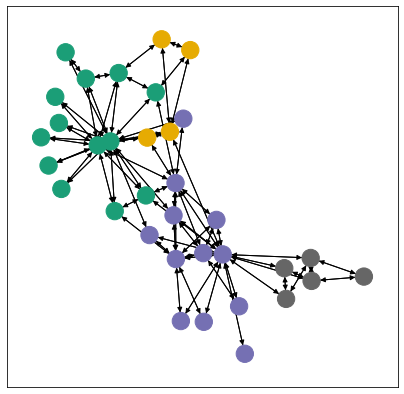

In [ ]:
show_dataset_as_networkx_graph(KarateClub()[0])

In [ ]:
class HyperParameterCombinations:
    """
    To be manually configured
    """
    ES = [8]
    LR = [0.01, 0.001]
    WD = [1e-5, 1e-3]
    TR = [x / 10 for x in range(1, 9)]
    DATASET = [KarateClub()]
    EPOCHS = [250, 500, 1000]

In [ ]:
df = TrainAndCaptureResults().run()

Total combinations to run exp on: 96
Running combination: 1 of 96
Running combination: 2 of 96
Running combination: 3 of 96
Running combination: 4 of 96
Running combination: 5 of 96
Running combination: 6 of 96
Running combination: 7 of 96
Running combination: 8 of 96
Running combination: 9 of 96
Running combination: 10 of 96
Running combination: 11 of 96
Running combination: 12 of 96
Running combination: 13 of 96
Running combination: 14 of 96
Running combination: 15 of 96
Running combination: 16 of 96
Running combination: 17 of 96
Running combination: 18 of 96
Running combination: 19 of 96
Running combination: 20 of 96
Running combination: 21 of 96
Running combination: 22 of 96
Running combination: 23 of 96
Running combination: 24 of 96
Running combination: 25 of 96
Running combination: 26 of 96
Running combination: 27 of 96
Running combination: 28 of 96
Running combination: 29 of 96
Running combination: 30 of 96
Running combination: 31 of 96
Running combination: 32 of 96
Running comb

In [ ]:
df

,Embedding Size,Learning Rate,Weight Decay,Training Ratio,Dataset,Epochs,degree_centrality() error,in_degree_centrality() error,eigenvector_centrality() error,harmonic_centrality() error,closeness_centrality() error,betweenness_centrality() error,load_centrality() error,clustering() error,Average Error across 8-d
40,8,0.010,0.00100,0.6,KarateClub(),500,0.002271,0.000987,0.003367,0.000670,0.088105,0.004132,0.001925,1.712660,0.226765
41,8,0.010,0.00100,0.6,KarateClub(),1000,0.002415,0.001004,0.003528,0.000520,0.075589,0.003800,0.001282,1.894707,0.247856
37,8,0.010,0.00100,0.5,KarateClub(),500,0.002841,0.001732,0.003056,0.001120,0.082008,0.003533,0.002822,2.129219,0.278292
36,8,0.010,0.00100,0.5,KarateClub(),250,0.003200,0.001971,0.003008,0.000983,0.100472,0.003750,0.005300,2.162455,0.285142
13,8,0.010,0.00001,0.5,KarateClub(),500,0.002700,0.001749,0.002947,0.001509,0.079336,0.003652,0.006065,2.336830,0.304349
39,8,0.010,0.00100,0.6,KarateClub(),250,0.002939,0.001247,0.003463,0.000823,0.098771,0.004633,0.007617,2.329091,0.306073
44,8,0.010,0.00100,0.7,KarateClub(),1000,0.002293,0.000864,0.003531,0.000880,0.078379,0.003791,0.002288,2.363768,0.306974
14,8,0.010,0.00001,0.5,KarateClub(),1000,0.002246,0.002305,0.003838,0.005059,0.086895,0.002938,0.011238,2.464292,0.322351
46,8,0.010,0.00100,0.8,KarateClub(),500,0.002824,0.000957,0.004910,0.000973,0.085084,0.005866,0.002608,2.518607,0.327729
38,8,0.010,0.00100,0.5,KarateClub(),1000,0.002944,0.001717,0.003278,0.001288,0.073453,0.003480,0.003752,2.538353,0.328533


## Observation: 
nx.clustering() is something the GCN is having trouble learning as the MSE for it is the highest(second last column in the dataframe)

## Experiment on the Cora Dataset

In [ ]:
show_dataset_stats(Planetoid(root="delete_me/", name="Cora"))

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Processing...
Done!


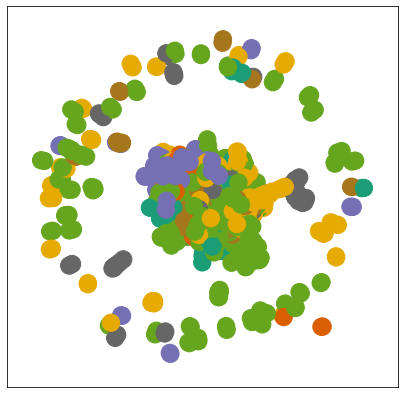

In [ ]:
show_dataset_as_networkx_graph(Planetoid(root="delete_me/", name="Cora")[0])

In [ ]:
class HyperParameterCombinations:
    """
    To be manually configured
    """
    ES = [8]
    LR = [0.01, 0.001]
    WD = [1e-5, 1e-3]
    TR = [x / 10 for x in range(1, 9)]
    DATASET = [Planetoid(root="delete_me/", name="Cora")]
    EPOCHS = [250, 500, 1000]

In [ ]:
df = TrainAndCaptureResults().run()

Total combinations to run exp on: 96
Running combination: 1 of 96
Running combination: 2 of 96
Running combination: 3 of 96
Running combination: 4 of 96
Running combination: 5 of 96
Running combination: 6 of 96
Running combination: 7 of 96
Running combination: 8 of 96
Running combination: 9 of 96
Running combination: 10 of 96
Running combination: 11 of 96
Running combination: 12 of 96
Running combination: 13 of 96
Running combination: 14 of 96
Running combination: 15 of 96
Running combination: 16 of 96
Running combination: 17 of 96
Running combination: 18 of 96
Running combination: 19 of 96
Running combination: 20 of 96
Running combination: 21 of 96
Running combination: 22 of 96
Running combination: 23 of 96
Running combination: 24 of 96
Running combination: 25 of 96
Running combination: 26 of 96
Running combination: 27 of 96
Running combination: 28 of 96
Running combination: 29 of 96
Running combination: 30 of 96
Running combination: 31 of 96
Running combination: 32 of 96
Running comb

In [ ]:
df

,Embedding Size,Learning Rate,Weight Decay,Training Ratio,Dataset,Epochs,degree_centrality() error,in_degree_centrality() error,eigenvector_centrality() error,harmonic_centrality() error,closeness_centrality() error,betweenness_centrality() error,load_centrality() error,clustering() error,Average Error across 8-d
95,8,0.001,0.00100,0.8,Cora(),1000,0.024972,0.029743,0.031551,0.069798,0.138595,0.060683,0.070437,15566.503906,1945.866211
71,8,0.001,0.00001,0.8,Cora(),1000,0.083509,0.026594,0.050116,0.069601,0.148666,0.042120,0.080650,15612.770508,1951.658936
45,8,0.010,0.00100,0.8,Cora(),250,0.124535,0.145862,0.080434,0.025202,0.113862,0.070916,0.035634,16104.909180,2013.188232
21,8,0.010,0.00001,0.8,Cora(),250,0.157896,0.043151,0.129078,0.035033,0.120338,0.113249,0.096626,16115.996094,2014.586426
46,8,0.010,0.00100,0.8,Cora(),500,0.020910,0.062599,0.012228,0.021528,0.148964,0.022553,0.015252,17171.150391,2146.431885
22,8,0.010,0.00001,0.8,Cora(),500,0.029585,0.048142,0.009057,0.036089,0.132696,0.055661,0.089739,17339.687500,2167.510986
68,8,0.001,0.00001,0.7,Cora(),1000,0.032240,0.035823,0.064390,0.091505,0.159671,0.034719,0.053761,18438.843750,2304.914551
92,8,0.001,0.00100,0.7,Cora(),1000,0.025700,0.040857,0.049761,0.072356,0.143601,0.044402,0.063495,18451.419922,2306.482422
65,8,0.001,0.00001,0.6,Cora(),1000,0.028407,0.034547,0.050172,0.057317,0.133968,0.044824,0.056721,18464.138672,2308.068115
39,8,0.010,0.00100,0.6,Cora(),250,0.125572,0.050812,0.049626,0.017670,0.115865,0.056653,0.017263,18641.697266,2330.266357


## Experiment on Citeceer Dataset

In [ ]:
show_dataset_stats(Planetoid(root="delete_me/", name="CiteSeer"))

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True


Processing...
Done!


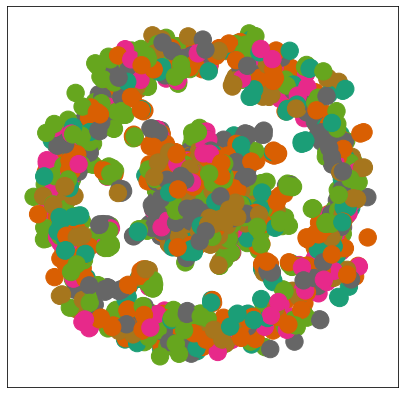

In [ ]:
show_dataset_as_networkx_graph(Planetoid(root="delete_me/", name="CiteSeer")[0])

In [ ]:
class HyperParameterCombinations:
    """
    To be manually configured
    """
    ES = [8]
    LR = [0.01, 0.001]
    WD = [1e-5, 1e-3]
    TR = [x / 10 for x in range(1, 9)]
    DATASET = [Planetoid(root="delete_me/", name="CiteSeer")]
    EPOCHS = [250, 500, 1000]


In [ ]:
df = TrainAndCaptureResults().run()

Total combinations to run exp on: 96
Running combination: 1 of 96
Running combination: 2 of 96
Running combination: 3 of 96
Running combination: 4 of 96
Running combination: 5 of 96
Running combination: 6 of 96
Running combination: 7 of 96
Running combination: 8 of 96
Running combination: 9 of 96
Running combination: 10 of 96
Running combination: 11 of 96
Running combination: 12 of 96
Running combination: 13 of 96
Running combination: 14 of 96
Running combination: 15 of 96
Running combination: 16 of 96
Running combination: 17 of 96
Running combination: 18 of 96
Running combination: 19 of 96
Running combination: 20 of 96
Running combination: 21 of 96
Running combination: 22 of 96
Running combination: 23 of 96
Running combination: 24 of 96
Running combination: 25 of 96
Running combination: 26 of 96
Running combination: 27 of 96
Running combination: 28 of 96
Running combination: 29 of 96
Running combination: 30 of 96
Running combination: 31 of 96
Running combination: 32 of 96
Running comb

In [ ]:
df

,Embedding Size,Learning Rate,Weight Decay,Training Ratio,Dataset,Epochs,degree_centrality() error,in_degree_centrality() error,eigenvector_centrality() error,harmonic_centrality() error,closeness_centrality() error,betweenness_centrality() error,load_centrality() error,clustering() error,Average Error across 8-d
71,8,0.001,0.00001,0.8,CiteSeer(),1000,0.068427,0.067088,0.073352,0.029156,0.119740,0.019585,0.057627,4198.716309,524.893921
45,8,0.010,0.00100,0.8,CiteSeer(),250,0.042475,0.011257,0.025724,0.019756,0.093662,0.005025,0.007649,4203.181152,525.423340
21,8,0.010,0.00001,0.8,CiteSeer(),250,0.023438,0.017965,0.026606,0.026574,0.087418,0.005909,0.011811,4215.046387,526.905762
95,8,0.001,0.00100,0.8,CiteSeer(),1000,0.055859,0.070822,0.048406,0.019599,0.104446,0.010341,0.040072,4280.106934,535.057068
42,8,0.010,0.00100,0.7,CiteSeer(),250,0.008543,0.010931,0.030213,0.019315,0.085837,0.005264,0.006331,4633.172363,579.167358
18,8,0.010,0.00001,0.7,CiteSeer(),250,0.022788,0.016778,0.030212,0.029114,0.086780,0.004736,0.011034,4655.051270,581.906616
68,8,0.001,0.00001,0.7,CiteSeer(),1000,0.060464,0.053370,0.061419,0.024847,0.116237,0.024156,0.063678,4666.300781,583.338135
94,8,0.001,0.00100,0.8,CiteSeer(),500,0.070076,0.110879,0.073922,0.038393,0.134379,0.022499,0.088092,4789.272949,598.726379
91,8,0.001,0.00100,0.7,CiteSeer(),500,0.064968,0.096274,0.058994,0.038267,0.121449,0.019730,0.078187,4920.212402,615.086304
70,8,0.001,0.00001,0.8,CiteSeer(),500,0.091657,0.106729,0.086770,0.043092,0.153976,0.026288,0.100963,4958.395020,619.875549


# Inferences
### Clustering Coefficient is hard for GCNs to learn.
Looking at error values for 8 different stats for 3 different datasets, clustering() is what the GCN is having the highest trouble learning. This is expected as clustering as implemented in networkx [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html), is networkx's implementation of clustering coefficient for each node. As shown in [Identity-aware Graph Neural Networks](https://arxiv.org/pdf/2101.10320.pdf), learning clustering coefficient is a known limitation of Graph Neural Networks.

### What are all the stats available and what subset of them are learnable? 
Exploring more node stats available in nx and what subset of it has lower error values is something to explore further.